In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pathlib
import pandas as pd
from os.path import isfile
from fastai.vision import *
from fastai.callbacks import *
from fastai.metrics import fbeta, error_rate
import libsixel

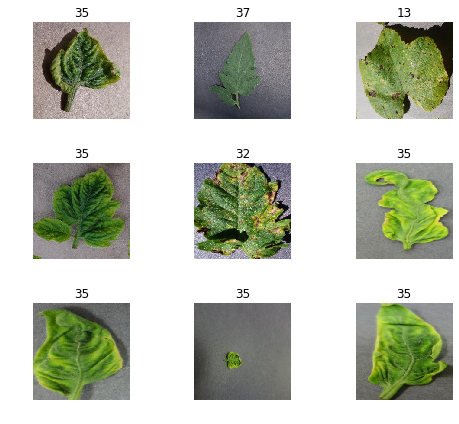

In [3]:
def get_train_val_for_fastai(input_csv):
    original_data = pd.read_csv(input_csv)
    df_for_fastai = original_data[['relative_path', 'label', 'is_valid']]
    return df_for_fastai

def get_data_for_learner(df, dataset_path, tfms, stats):
    data = (ImageList.from_df(df, dataset_path)
                 .split_from_df()
                 .label_from_df(cols=1)
                 .transform(tfms, size=224)
                 .databunch(bs=64)
                 .normalize(stats))
    return data

df_train_val_for_fastai = get_train_val_for_fastai(str(pathlib.Path.cwd()) + "/temp/" + "train_val_group.csv")

tfms = get_transforms(flip_vert=False, max_rotate=25)

plantVillage_stats = ([0.466, 0.489, 0.41], [0.199, 0.175, 0.218])
data = get_data_for_learner(df_train_val_for_fastai, str(pathlib.Path.cwd()) + "/raw_datasets/images/plantVillage", 
                            tfms, plantVillage_stats)

data.show_batch(rows=3, figsize=(7,6))

In [4]:
print(data.classes)
len(data.classes), data.c

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]


(38, 38)

In [5]:
learn = cnn_learner(data, 
                    models.resnet50, 
                    metrics=error_rate, 
                    callback_fns=[partial(CSVLogger, filename='group_history', append=True)])

In [6]:
model_summary(learn)

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________

In [9]:
if isfile(str(pathlib.Path.cwd()) + "/models/" + "resnet50_stage_1_group.pth"):
    train_history = pd.read_csv(str(learn.path) + "/group_history.csv")
    print(train_history)
    learn.load(str(pathlib.Path.cwd()) + "/models/" + "resnet50_stage_1_group");
else:
    learn.fit_one_cycle(5)
    learn.save(str(pathlib.Path.cwd()) + "/models/" + "resnet50_stage_1_group")

   epoch  train_loss  valid_loss  error_rate   time
0      0    0.232690    0.125903    0.038491  02:22
1      1    0.130053    0.068135    0.023512  02:20
2      2    0.074010    0.040520    0.013273  02:21
3      3    0.037107    0.022954    0.009101  02:22
4      4    0.029019    0.023122    0.008722  02:22


In [10]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

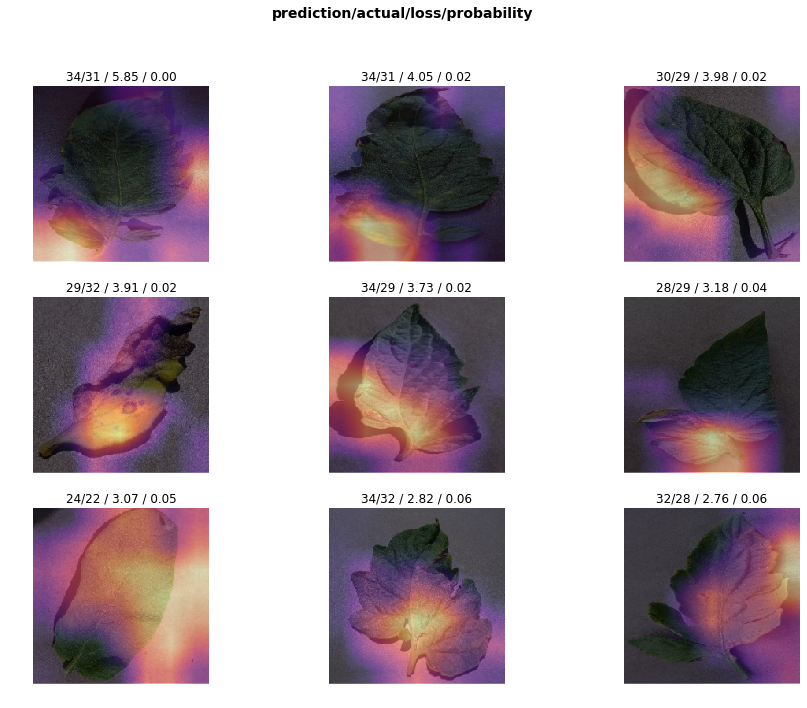

In [11]:
interp.plot_top_losses(9, figsize=(15,11))

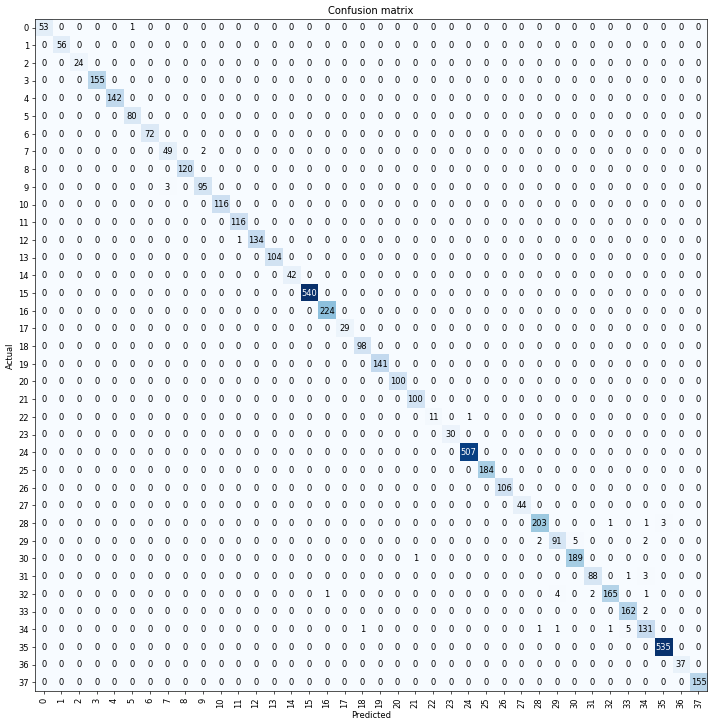

In [12]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [13]:
interp.most_confused(min_val=2)

[(29, 30, 5),
 (34, 33, 5),
 (32, 29, 4),
 (9, 7, 3),
 (28, 35, 3),
 (31, 34, 3),
 (7, 9, 2),
 (29, 28, 2),
 (29, 34, 2),
 (32, 31, 2),
 (33, 34, 2)]

In [14]:
learn.unfreeze()

In [15]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.050490,0.022239,0.007395,03:13


In [16]:
learn.load(str(pathlib.Path.cwd()) + "/models/" + "resnet50_stage_1_group");

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.79E-06


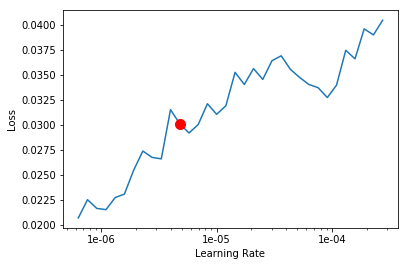

In [18]:
learn.recorder.plot(suggestion=True)

In [19]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.040180,0.020716,0.006447,03:13
1,0.018005,0.015022,0.005119,03:14


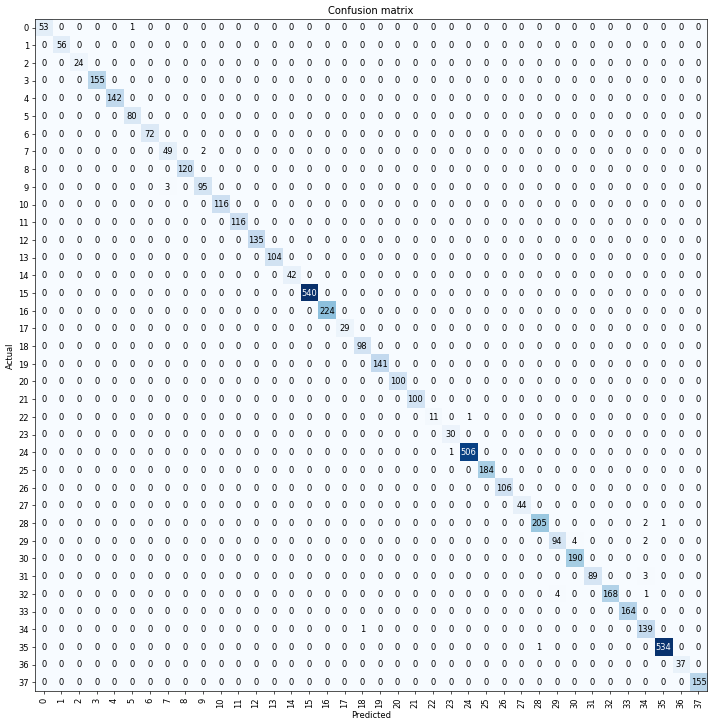

In [32]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [30]:
probs, val_labels = learn.get_preds(ds_type=DatasetType.Valid)

class_num = probs.size()[1]
diag_one = torch.sparse.torch.eye(class_num)

probs_max_index = torch.argmax(probs, dim=1)

probs_one_hot = diag_one.index_select(0, probs_max_index)
val_labels_one_hot = diag_one.index_select(0, val_labels)

result = []

for index_column in range(probs.size()[1]):
    prob_each_disease = probs[:, index_column].view(1,-1)
    label_each_disease = val_labels_one_hot[:, index_column].view(1,-1)
    f1_score = fbeta(prob_each_disease, label_each_disease, thresh=0.5, beta=1, sigmoid=False).numpy()
    f1_score = np.around(f1_score, decimals=2)
    result.append(str(index_column) + "\t" + str(f1_score))

print("Label   F1-score")
print('\n'.join(result))

Label   F1-score
0	0.99
1	1.0
2	1.0
3	1.0
4	1.0
5	0.99
6	1.0
7	0.95
8	1.0
9	0.97
10	1.0
11	1.0
12	1.0
13	1.0
14	1.0
15	1.0
16	1.0
17	1.0
18	0.99
19	1.0
20	1.0
21	1.0
22	0.96
23	0.98
24	1.0
25	1.0
26	1.0
27	1.0
28	0.99
29	0.95
30	0.99
31	0.98
32	0.99
33	1.0
34	0.98
35	1.0
36	1.0
37	1.0
